In [457]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [458]:
#読み込み
train_df = pd.read_csv("../input/titanic/train.csv")
test_df = pd.read_csv("../input/titanic/test.csv")

In [459]:
#テストにサバイブ列（NaN）追加
test_df['Survived'] = np.nan

In [460]:
#二つ合体
df = pd.concat([train_df, test_df], ignore_index=True, sort=False)

In [461]:
#ランダムフォレストをインポート
from sklearn.ensemble import RandomForestRegressor

In [462]:
#Ageとか抜き出し
age_df = df[['Age','Pclass','Sex','Parch','SibSp']]

In [463]:
#Pclassとかワンホット
age_df=pd.get_dummies(age_df)

In [464]:
#ヌルとちゃうやつ分ける
known_age = age_df[age_df.Age.notnull()].values  
unknown_age = age_df[age_df.Age.isnull()].values

In [465]:
#yが'Age'、Xが'Pclass','Sex','Parch','SibSp'
X = known_age[:, 1:]  
y = known_age[:, 0]

In [466]:
#ランダムフォレスト
rfr = RandomForestRegressor(random_state=0, n_estimators=100, n_jobs=-1)

In [467]:
#学習
rfr.fit(X, y)

RandomForestRegressor(n_jobs=-1, random_state=0)

In [468]:
#予測
predictedAges = rfr.predict(unknown_age[:, 1::])

In [469]:
#予測Ageはめ込み
df.loc[(df.Age.isnull()), 'Age'] = predictedAges 

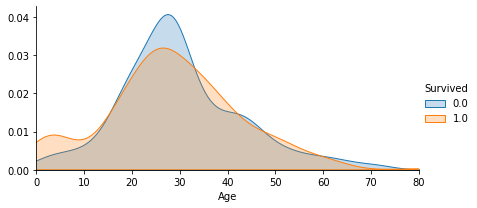

In [470]:
#マップで見てみる
import seaborn as sns
import matplotlib.pyplot as plt
facet = sns.FacetGrid(df[0:890], hue="Survived",aspect=2)
facet.map(sns.kdeplot,'Age',shade= True)
facet.set(xlim=(0, df.loc[0:890,'Age'].max()))
facet.add_legend()
plt.show()

In [471]:
#EmbarkedがSでPclassが3の行のfareの中央値
fare=df.loc[(df['Embarked'] == 'S') & (df['Pclass'] == 3), 'Fare'].median()

In [472]:
#ヌルにはめ込む
df['Fare']=df['Fare'].fillna(fare)

In [473]:
#Nameの","の後ろと"."の前をTitleとして抜き出し
df['Title'] = df['Name'].map(lambda x: x.split(', ')[1].split('. ')[0])

<AxesSubplot:xlabel='Title', ylabel='Survived'>

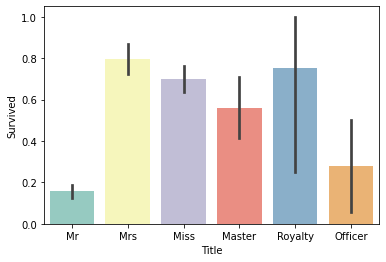

In [474]:
#Titleの文字をそれぞれ変更
df['Title'].replace(['Capt', 'Col', 'Major', 'Dr', 'Rev'], 'Officer', inplace=True)
df['Title'].replace(['Don', 'Sir',  'the Countess', 'Lady', 'Dona'], 'Royalty', inplace=True)
df['Title'].replace(['Mme', 'Ms'], 'Mrs', inplace=True)
df['Title'].replace(['Mlle'], 'Miss', inplace=True)
df['Title'].replace(['Jonkheer'], 'Master', inplace=True)
sns.barplot(x='Title', y='Survived', data=df, palette='Set3')

In [475]:
#Nameの","の前をSurnameとして抜き出し
df['Surname'] = df['Name'].map(lambda name:name.split(',')[0].strip())

In [476]:
#FamilyGroupはSurnameの出現回数
df['FamilyGroup'] = df['Surname'].map(df['Surname'].value_counts()) 

In [477]:
#家族の女か子供をFemale_Child_Groupに抜き出し、Survived値の平均
Female_Child_Group=df.loc[(df['FamilyGroup']>=2) & ((df['Age']<=16) | (df['Sex']=='female'))]
Female_Child_Group=Female_Child_Group.groupby('Surname')['Survived'].mean()

In [478]:
#家族の男をMale_Adult_Groupに抜き出し、Survived値の平均
Male_Adult_Group=df.loc[(df['FamilyGroup']>=2) & (df['Age']>16) & (df['Sex']=='male')]
Male_Adult_List=Male_Adult_Group.groupby('Surname')['Survived'].mean()

In [479]:
#Dead_listリスト作成。ｘ==0で全員死ん女、子供家族の苗字一覧
Dead_list=set(Female_Child_Group[Female_Child_Group.apply(lambda x:x==0)].index)

In [480]:
#Survived_listリスト作成。ｘ==1で全員生きた男家族の苗字一覧
Survived_list=set(Male_Adult_List[Male_Adult_List.apply(lambda x:x==1)].index)

In [481]:
#それぞれ学習しやすいよう該当者を典型的な死亡データと生存データに入れ替える
df.loc[(df['Survived'].isnull()) & (df['Surname'].apply(lambda x:x in Dead_list)),\
       ['Sex','Age','Title']] = ['male',28.0,'Mr']
df.loc[(df['Survived'].isnull()) & (df['Surname'].apply(lambda x:x in Survived_list)),\
       ['Sex','Age','Title']] = ['female',5.0,'Mrs']

In [482]:
#兄弟と親、子供に自分の1を足して、家族の数にする
df['Family']=df['SibSp']+df['Parch']+1

In [483]:
#家族の人数が2~4はラベル2、5~7か1はラベル1、8以上はラベル0をつける
df.loc[(df['Family']>=2) & (df['Family']<=4), 'Family_label'] = 2
df.loc[(df['Family']>=5) & (df['Family']<=7) | (df['Family']==1), 'Family_label'] = 1  # == に注意
df.loc[(df['Family']>=8), 'Family_label'] = 0

In [484]:
#チケットが何個あるかの羅列
Ticket_Count = dict(df['Ticket'].value_counts())

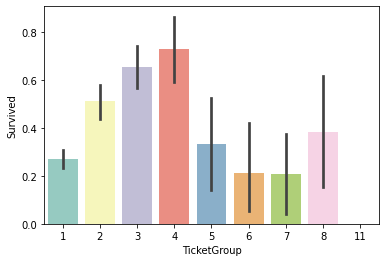

In [485]:
#TicketGroupはチケットが何個あるやつか
df['TicketGroup'] = df['Ticket'].map(Ticket_Count)
sns.barplot(x='TicketGroup', y='Survived', data=df, palette='Set3')
plt.show()

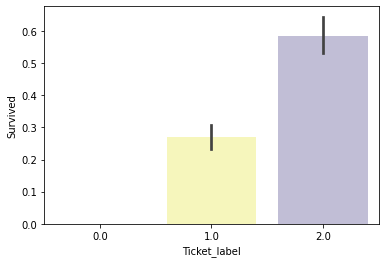

In [486]:
#TicketGroupが2~4はラベル2、5~8か1はラベル1、11以上はラベル0をつける#
df.loc[(df['TicketGroup']>=2) & (df['TicketGroup']<=4), 'Ticket_label'] = 2
df.loc[(df['TicketGroup']>=5) & (df['TicketGroup']<=8) | (df['TicketGroup']==1), 'Ticket_label'] = 1  
df.loc[(df['TicketGroup']>=11), 'Ticket_label'] = 0
sns.barplot(x='Ticket_label', y='Survived', data=df, palette='Set3')
plt.show()

In [487]:
#'Cabin'で埋まってないのをUnknownで埋める
df['Cabin'] = df['Cabin'].fillna('Unknown')

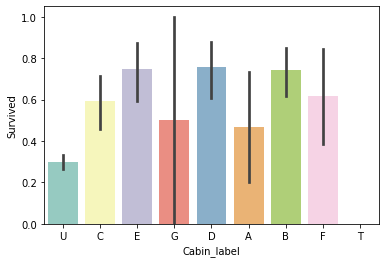

In [488]:
#最初の文字をとったやつをCabin_labelにする
df['Cabin_label']=df['Cabin'].str.get(0)
sns.barplot(x='Cabin_label', y='Survived', data=df, palette='Set3')
plt.show()

In [489]:
#'Embarked'を一番多いSで埋める
df['Embarked'] = df['Embarked'].fillna('S') 

In [490]:
#使う列の指定
df = df[['Survived','Pclass','Sex','Age','Fare','Embarked','Title','Family_label','Cabin_label','Ticket_label']]

In [491]:
#ワンホット
df = pd.get_dummies(df)

In [492]:
#dfのをtrainとtestに分ける
#合体の時に追加してたテストのSurvived列を消す
train = df[df['Survived'].notnull()]
test = df[df['Survived'].isnull()].drop('Survived',axis=1)

In [493]:
#Values関数でNumpy配列に
#Numpy配列のほうが計算早い
X = train.values[:,1:]  
y = train.values[:,0] 
test_x = test.values

In [494]:
#ランダムフォレストとかインポート
from sklearn.feature_selection import SelectKBest
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_validate

In [495]:
#使う列（特徴）の数
select = SelectKBest(k = 20)

In [496]:
#ランダムフォレスト
clf = RandomForestClassifier(random_state = 10, 
                             warm_start = True,  
                             n_estimators = 26,
                             max_depth = 6, 
                             max_features = 'sqrt')

In [497]:
#パイプラインでランダムフォレストまで一気に
pipeline = make_pipeline(select, clf)

In [498]:
#パイプライン学習
pipeline.fit(X, y)

Pipeline(steps=[('selectkbest', SelectKBest(k=20)),
                ('randomforestclassifier',
                 RandomForestClassifier(max_depth=6, max_features='sqrt',
                                        n_estimators=26, random_state=10,
                                        warm_start=True))])

In [499]:
#結果見てみる
#Cross Validationはモデルがどれだけ正確か測る
cv_result = cross_validate(pipeline, X, y, cv= 10)
print('mean_score = ', np.mean(cv_result['test_score']))
print('mean_std = ', np.std(cv_result['test_score']))

/opt/conda/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:115: UserWarning: Features [23] are constant.
  UserWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


mean_score =  0.8395006242197255
mean_std =  0.049770983038016456


In [500]:
#使った行（特徴）どこか
mask= select.get_support()

In [501]:
#行（特徴）のリスト
list_col = list(df.columns[1:])

In [502]:
#合わせて使った行一覧表
for i, j in enumerate(list_col):
    print('No'+str(i+1), j,'=',  mask[i])

No1 Pclass = True
No2 Age = True
No3 Fare = True
No4 Family_label = True
No5 Ticket_label = True
No6 Sex_female = True
No7 Sex_male = True
No8 Embarked_C = True
No9 Embarked_Q = False
No10 Embarked_S = True
No11 Title_Master = True
No12 Title_Miss = True
No13 Title_Mr = True
No14 Title_Mrs = True
No15 Title_Officer = False
No16 Title_Royalty = True
No17 Cabin_label_A = False
No18 Cabin_label_B = True
No19 Cabin_label_C = True
No20 Cabin_label_D = True
No21 Cabin_label_E = True
No22 Cabin_label_F = True
No23 Cabin_label_G = False
No24 Cabin_label_T = False
No25 Cabin_label_U = True


In [503]:
#使う行で抜き出し
X_selected = select.transform(X)
print('X.shape={}, X_selected.shape={}'.format(X.shape, X_selected.shape))

X.shape=(891, 25), X_selected.shape=(891, 20)


In [504]:
#PassengerId取り出し
PassengerId=test_df['PassengerId']

In [505]:
#test_xを予測
predictions = pipeline.predict(test_x)

In [506]:
#提出物データフレーム作成
submission = pd.DataFrame({"PassengerId": PassengerId, "Survived": predictions.astype(np.int32)})

In [507]:
#csv作成
submission.to_csv("my_submission.csv", index=False)